In [79]:
import numpy as np
import matplotlib
#allow for latex markup in matplotlib figures
matplotlib.rcParams['text.usetex'] = False
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap


#Import a few utility functions...
import sys  
from pathlib import Path
sys.path.insert(0, "../comm_channel")
sys.path.insert(0, "../polling_systems")
sys.path.insert(0, "../geometry")
sys.path.insert(0, "../utils")

#So we can import my local libs
import CommChannel as CC
import qos
import pointcloud as PC
import TSPN
import PollingSystem as PS
import MarkovianRP as MRP
import dtr
import motion
import TSPN 

import sim_template as sim
from importlib import reload 

In [80]:
#setup quality of service requirements using reasonable values
F5GHz, F2_4GHz = 5, 2.4 #typical wifi frequencies are 2.4, 5, and sometiems 6 GHz
MOBILE_TX_POWER = qos.Pwr(20)#100-200mW (20-23 dBm) pretty typical, with 1W (30dBm) the absolute maximum
print(MOBILE_TX_POWER)
r = 8#any of 2, 4, 6, or 8
rx_noise = qos.Pwr(-85)#based on Yan and MostofiTWC13 #1e-10#
print(rx_noise)
BER = 1e-6
GAMMA_TH = qos.QoSReq(BER, r, rx_noise).thresholdChannelGain(MOBILE_TX_POWER)
print(GAMMA_TH)
print('SNR Threshold: %d'%(GAMMA_TH+MOBILE_TX_POWER.dBm - rx_noise.dBm))

20.000000 dBm	-10.000000 dBW	100.000000 mW	0.100000 W
-85.000000 dBm	-115.000000 dBW	0.000000 mW	0.000000 W
-71.8297512825111
SNR Threshold: 33


In [86]:
#Setup the communication environment:

#For now, use same channel params
nPL = 5.3
kPL = -20

decorrSH = 2.09  
alpha = 16
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1.5


#12 remote stations
l = 11
qBase = np.array([[2,6],[21,3],
                 [16,11],[28,23],
                 [10,22],[11,39],
                 [30, 11],[48, 8],
                 [18, 36],[35, 41],
                 [32, 33],[48, 25]])

sub_regions = [[25,0,10,0],
               [30,10, 25, 9],
               [20,0, 40, 17],
               [50, 25, 15, 3],
               [38, 15, 45, 27],
               [50, 30, 40, 20]]


x_max = 50
x_min = 0
y_max = 50
y_min = 0
region = [x_max, x_min, y_max, y_min]


cps = [CC.ChannelParams(qBase[i], nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]



#res = 2/decorrMP
res = 10
n = 6
p_th = 0.5

#Polling System Setup
bandwidth = 2#leave bandwidth in MHz*1000000#give ourselfes 2MHz of BW
beta = 1/(r*bandwidth)
print(beta)
els = [0.1/beta, 0.2/beta, 0.01/beta, 0.05/beta, 0.02/beta, 0.1/beta]
print(els)

0.0625
[1.6, 3.2, 0.16, 0.8, 0.32, 1.6]


In [82]:
reload(sim)
ccs, cfs, true_joint_con_fields, tjcps = sim.create_channels(cps, region, res, GAMMA_TH, sub_regions)

Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing genera

In [83]:
reload(sim)
pcs, pfs, pjcps, prob_pred_con = sim.predict_channels(res, ccs, true_joint_con_fields, GAMMA_TH, p_th=p_th)
trismall_pcs = pcs
#%store trismall_pcs
print(prob_pred_con)

Drawing 250 samples from Channel 1
Completed PredictedChannel 1
Drawing 250 samples from Channel 2
Completed PredictedChannel 2
Drawing 320 samples from Channel 3
Completed PredictedChannel 3
Drawing 320 samples from Channel 4
Completed PredictedChannel 4
Drawing 460 samples from Channel 5
Completed PredictedChannel 5
Drawing 460 samples from Channel 6
Completed PredictedChannel 6
Drawing 300 samples from Channel 7
Completed PredictedChannel 7
Drawing 300 samples from Channel 8
Completed PredictedChannel 8
Drawing 414 samples from Channel 9
Completed PredictedChannel 9
Drawing 414 samples from Channel 10
Completed PredictedChannel 10
Drawing 400 samples from Channel 11
Completed PredictedChannel 11
Drawing 400 samples from Channel 12
Completed PredictedChannel 12
[0.5666666666666667, 0.7896839811115147, 0.7775919732441472, 0.8048780487804879, 0.7749712973593571, 0.7482993197278912]


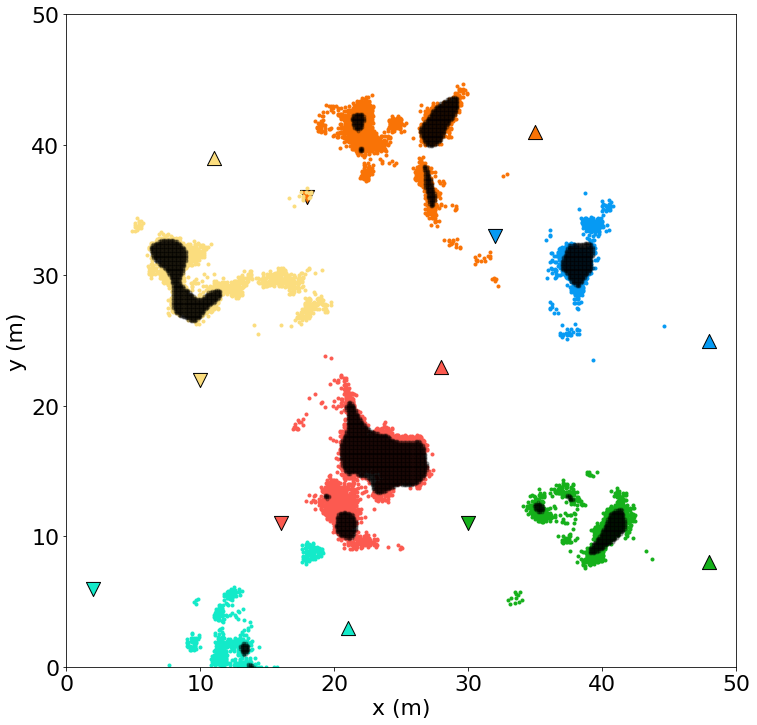

In [84]:
reload(sim)
sim.plotCFwithOverlay(n, tjcps, pjcps, qBase, region)
plt.gca().invert_yaxis()
plt.show()

In [87]:
reload(TSPN)
reload(PC)
reload(dtr)
dt_sys = dtr.DTR(pcs, region, els, beta, th=GAMMA_TH, p_th = p_th)
regions = dt_sys.cregions

Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
3 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
12 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
6 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
6 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 4 possibly non-convex polygons
9 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
4 total subregions


In [91]:
reload(TSPN)
tspn_min, tspn_argmin = TSPN.TSPN_BF(regions)
x=tspn_argmin[0]

Total of 60 Permutations to Try
Working on Permutation (0, 1, 2, 3, 4, 5)
Optimal Solution Improved to 130.47
Working on Permutation (0, 1, 2, 3, 5, 4)
Optimal Solution Improved to 123.46
Working on Permutation (0, 1, 2, 4, 3, 5)
Working on Permutation (0, 1, 2, 4, 5, 3)
Optimal Solution Improved to 100.23
Working on Permutation (0, 1, 2, 5, 3, 4)
skiping based on lower bound
Working on Permutation (0, 1, 2, 5, 4, 3)
skiping based on lower bound
Working on Permutation (0, 1, 3, 2, 4, 5)
skiping based on lower bound
Working on Permutation (0, 1, 3, 2, 5, 4)
skiping based on lower bound
Working on Permutation (0, 1, 3, 4, 2, 5)
skiping based on lower bound
Working on Permutation (0, 1, 3, 4, 5, 2)
skiping based on lower bound
Working on Permutation (0, 1, 3, 5, 2, 4)
skiping based on lower bound
Working on Permutation (0, 1, 3, 5, 4, 2)
Optimal Solution Improved to 98.18
Working on Permutation (0, 1, 4, 2, 3, 5)
skiping based on lower bound
Working on Permutation (0, 1, 4, 2, 5, 3)
skipi

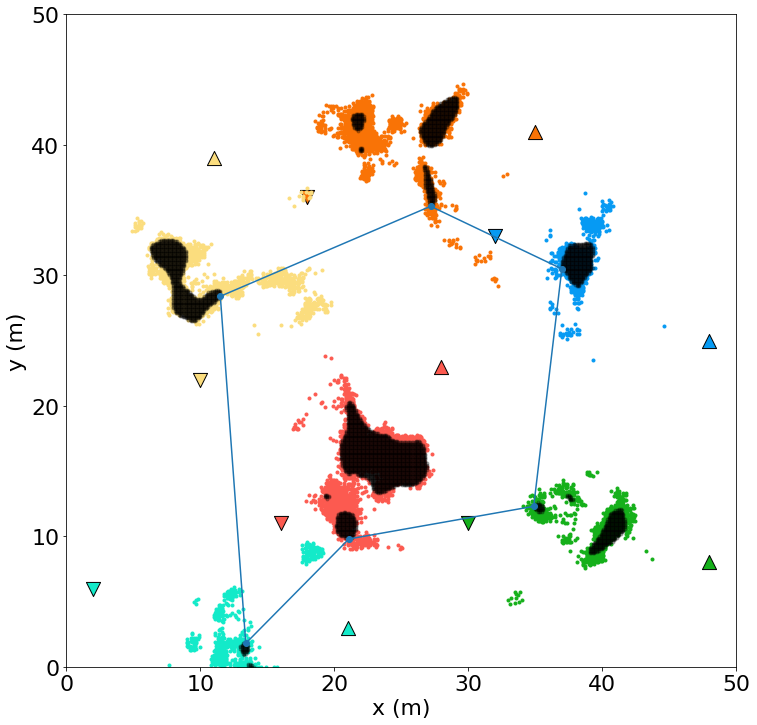

(0, 1, 3, 5, 4, 2)

In [92]:
reload(sim)
order = list(tspn_argmin[1])
order.append(0)#complete the loop
sim.plotCFwithOverlay(n, tjcps, pjcps, qBase, region)
plt.plot(x[order,0], x[order,1], zorder=100)
plt.scatter(x[:,0], x[:,1], zorder = 100)
plt.gca().invert_yaxis()
plt.show()

tspn_argmin[1]